# 3.2 Whale Ego Graphs (Local Structure Analysis)

In this notebook, we visualize the **ego graphs** of selected whales.

We focus on three categories:

1. **Value whales**  
2. **Centrality whales**  
3. **Overlap whales** (both value-based and centrality-based)

An ego graph shows the local 1-hop neighborhood around a node, illustrating:

- The types of addresses it interacts with  
- The diversity of its connections  
- Whether it acts as a hub, bridge or intermediary  
- Token vs ETH transfer patterns  

These visualizations help characterize the structural roles of different whales.

## 1. Imports + Load Graph + Load Whale Labels

We load:

- The heterogeneous graph `G` (from 2.3)
- The whale detection table (from 3.1)



In [2]:
import os
import sys
import random

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import pickle
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

# print("PROJECT_ROOT:", PROJECT_ROOT)

from src.data.load_data import (
    load_clean_transactions,
)


In [4]:
# Load graph
HETERO_GRAPH_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "heterogeneous_graph.gpickle")
if not os.path.exists(HETERO_GRAPH_PATH):
    raise FileNotFoundError("Run 2.3 to generate this graph.")
with Path(HETERO_GRAPH_PATH).open("rb") as f:
    G = pickle.load(f)
print("Loaded heterogeneous graph G")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Loaded heterogeneous graph G
Nodes: 26447
Edges: 30638


In [6]:
# Load whale detection results from 3.1
WHALE_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "whale_detection_value_and_centrality.parquet")
whales = pd.read_parquet(WHALE_PATH)

print("Loaded whale table:", whales.shape)
whales.head()


Loaded whale table: (7796, 20)


,total_out_value,n_out_tx,total_in_value,n_in_tx,n_total_tx,net_flow,is_out_whale,is_in_whale,is_whale_value,in_degree,out_degree,degree,pagerank,hub_score,authority_score,is_whale_degree,is_whale_pagerank,is_whale_authority,is_whale_centrality,is_whale
0x0000000000000068f116a894984e2db1123eb395,0.0,0.0,9.491430e+19,15.0,15.0,9.491430e+19,False,False,False,14,0,14,0.000286,-0.000000,2.274776e-17,False,False,False,False,False
0x0000000000001ff3684f28c67538d4d072c22734,0.0,0.0,6.716182e+20,47.0,47.0,6.716182e+20,False,False,False,40,0,40,0.000513,-0.000000,6.715330e-04,False,False,False,False,False
0x0000000000a39bb272e79075ade125fd351887ac,0.0,0.0,1.401000e+20,23.0,23.0,1.401000e+20,False,False,False,20,0,20,0.000374,-0.000000,8.615999e-06,False,False,False,False,False
0x00000000219ab540356cbb839cbe05303d7705fa,0.0,0.0,1.853817e+22,347.0,347.0,1.853817e+22,False,False,False,311,0,311,0.006200,-0.000000,3.904840e-09,True,True,False,True,True
0x00000047bb99ea4d791bb749d970de71ee0b1a34,0.0,0.0,1.306812e+20,15.0,15.0,1.306812e+20,False,False,False,10,2,12,0.000195,0.000036,2.554334e-04,False,False,False,False,False


## 2. Ego Graph Utilities

We reuse helper functions from Section 2.5 for consistency:

- `sample_ego_subgraph()`: extract a radius-1 ego graph with optional node cap.
- `draw_hetero_subgraph()`: visualize node_type + edge_type.


In [7]:
def sample_ego_subgraph(G, center_node, radius=1, max_nodes=150):
    """
    Extract a radius-1 or radius-2 ego graph.
    If too large, randomly trim it to at most `max_nodes`.
    """
    H = nx.ego_graph(G, center_node, radius=radius)
    
    if H.number_of_nodes() > max_nodes:
        keep = {center_node}
        others = [n for n in H.nodes() if n != center_node]
        others = np.random.choice(others, size=max_nodes - 1, replace=False)
        keep.update(others)
        H = H.subgraph(keep).copy()
        
    return H


def draw_hetero_subgraph(H, center_node=None, title=None):
    """
    Visualize the heterogeneous subgraph.
    """
    node_types = nx.get_node_attributes(H, "node_type")
    node_color_map = {
        "EOA": "tab:blue",
        "Contract": "tab:orange",
        "Token": "tab:green",
        "Unknown": "tab:gray",
    }
    node_colors = [node_color_map.get(node_types.get(n, "Unknown"), "tab:gray") for n in H.nodes()]
    
    # Edge types
    edge_types = nx.get_edge_attributes(H, "edge_type")
    edge_color_map = {
        "eth_transfer": "tab:gray",
        "token_transfer": "tab:red",
        "contract_call": "tab:purple",
    }
    edge_colors = [
        edge_color_map.get(edge_types.get((u, v, k), "Unknown"), "lightgray")
        for u, v, k in H.edges(keys=True)
    ]
    
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(H, k=0.35, iterations=50, seed=42)
    
    nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=80, alpha=0.9)
    nx.draw_networkx_edges(H, pos, edge_color=edge_colors, alpha=0.7, arrows=False)
    
    if center_node in H:
        nx.draw_networkx_nodes(
            H, pos, nodelist=[center_node],
            node_color="yellow", node_size=200, edgecolors="black"
        )
    
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


## 3. Select Whale Examples for Visualization

We choose representative whales from:

- **Top value whale**
- **Top PageRank whale**
- **Top degree whale**
- **Overlap whale** (value ∩ centrality)

This provides a diverse set of structural patterns.


In [9]:
# 1. Top value whale
top_value_whale = whales.sort_values("total_out_value", ascending=False).index[0]

# 2. Top PageRank whale
top_pr_whale = whales.sort_values("pagerank", ascending=False).index[0]

# 3. Top degree whale
top_degree_whale = whales.sort_values("degree", ascending=False).index[0]

# 4. Overlap whale (both value + centrality)
overlap_candidates = whales[
    (whales["is_whale_value"] == True) &
    (whales["is_whale_centrality"] == True)
]
top_overlap_whale = overlap_candidates.index[0] if len(overlap_candidates) > 0 else None

print("Top value whale:", top_value_whale)
print("Top PageRank whale:", top_pr_whale)
print("Top degree whale:", top_degree_whale)
print("Top overlap whale:", top_overlap_whale)


Top value whale: 0x28c6c06298d514db089934071355e5743bf21d60
Top PageRank whale: 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
Top degree whale: 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
Top overlap whale: 0x28c6c06298d514db089934071355e5743bf21d60


## 4. Ego Graph of the Top Value Whale

Value whales typically have:
- High transaction volume  
- Concentrated inflows/outflows  
- Patterns resembling exchange hot wallets or high-frequency traders


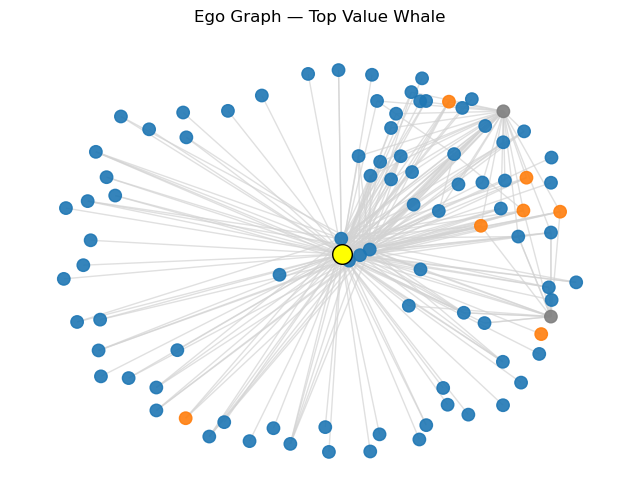

In [12]:
H_value = sample_ego_subgraph(G, top_value_whale, radius=1, max_nodes=150)
draw_hetero_subgraph(H_value, center_node=top_value_whale,
                     title="Ego Graph — Top Value Whale")


## 5. Ego Graph of the Top PageRank Whale

PageRank whales often:
- Receive transactions from many important addresses  
- Act as “liquidity hubs”


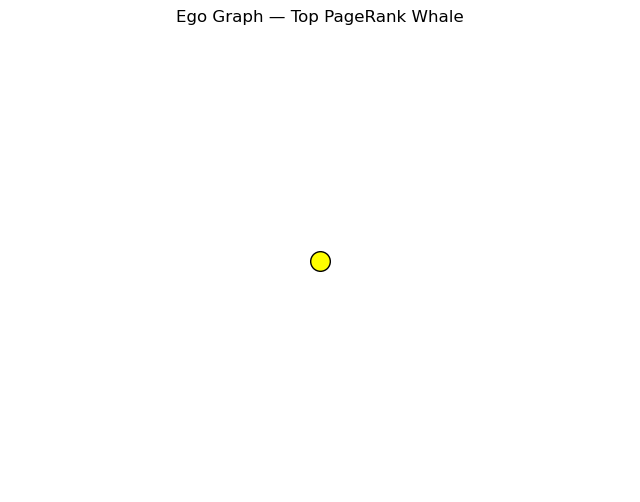

In [ ]:
H_pr = sample_ego_subgraph(G, top_pr_whale, radius=1, max_nodes=150)
draw_hetero_subgraph(H_pr, center_node=top_pr_whale,
                     title="Ego Graph — Top PageRank Whale")



## 6. Ego Graph of the Top Degree Whale

Degree whales typically:
- Have many direct neighbors  
- Can be smart contracts (DEX routers, token contracts, airdrop distributors)


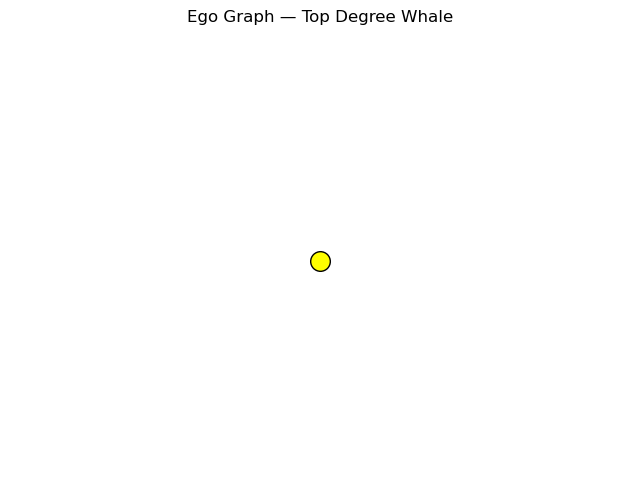

In [14]:
H_degree = sample_ego_subgraph(G, top_degree_whale, radius=1, max_nodes=150)
draw_hetero_subgraph(H_degree, center_node=top_degree_whale,
                     title="Ego Graph — Top Degree Whale")


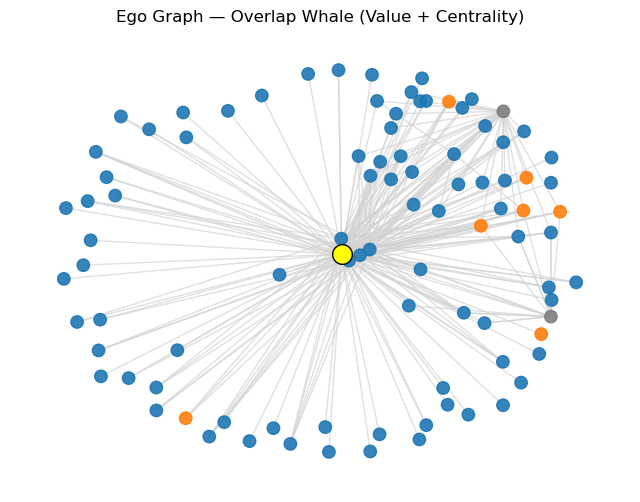

In [15]:
if top_overlap_whale is not None:
    H_overlap = sample_ego_subgraph(G, top_overlap_whale, radius=1, max_nodes=150)
    draw_hetero_subgraph(H_overlap, center_node=top_overlap_whale,
                         title="Ego Graph — Overlap Whale (Value + Centrality)")
else:
    print("No overlap whales detected in the dataset.")


## 8. Structural Interpretation

Based on the ego graphs:

### **Value whales**
- Often have few but large-value connections  
- Their ego graphs may show simple 1-to-N patterns  
- Reflect fund movement rather than network influence  

### **PageRank / degree whales**
- Exhibit high-connectivity neighborhoods  
- Often represent Smart Contracts (DEX, router, multi-sig)  
- Capture structural centrality rather than pure value dominance  

### **Overlap whales**
- Are rare but highly important  
- Combine both high value and high influence  
- Are prime candidates for flow analysis and risk assessment

These structural differences will guide the next stage:
**3.3 — Whale Flow & Time Series Behavior**.
